# Intent Classification For Chatbots With Applications For Querying Chicago Parks Department Event Website Using RF, SVM, and KNN models.

## Angelo Kelvakis
### DSC 540: ML Final Project

### Intro
This project looks at classifying subsets of text (intents) from a small repository found on github using Random Forest Classification, and SVM models. The data was formatted to hold one or several Intent classes per document with a Header section, an Intent Title, a list of several User Input examples, and a Bot Response. The original data was paired down and then appended with Chicago Parks Events specific user inputs, as well as several intents were increased in volume in order to better predict that specific class. In order to construct a model, the documents were translated into a pandas dataframe, and then tokenized and tf-idf transformed for model input. 

Original data source: https://github.com/jalizadeh/Chatbot-Dialog-Dataset

In [95]:
import numpy as np
import pandas as pd
from ast import literal_eval

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import neighbors, tree
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import random
import os
import re
import pandas as pd

### Document Processing

In [ ]:
def doc_processing(document):
    # collect index for all occurences of dashed lines
    p = [m.start() for m in re.finditer('------------------------', document)]
    intents_list = []
    # iterate through document and generate list between the dashed lines
    for i in range(0, len(p)):
        try:  # avoid last iteration
            intents_list.append(document[p[i]:p[i + 1]])
        except:
            intents_list.append(document[p[i]:])
    # remove the first line containing the info about document formatting
    intents_list = intents_list[1:]
    # create a tag counter to collect n-1 tags (there is no tag on the last list)
    tag_counter = len(intents_list) - 1
    # create counter for obtaining non-tag items
    counter = 1
    # create a tag list to store all tags
    tag_list = []
    # create list of user inputs
    user_list = []
    # create list of responses
    response_list = []

    # iterate through list of tags
    for l in intents_list:
        # split list by new line
        t = l.split('\n')
        # remove blank spaces
        while "" in t:
            t.remove("")

        # remove dashes separating tags
        t = t[1:]
        # collect the tags for each group of responses
        if tag_counter >= 1:
            # append to list of tags
            tag_list.append(t[-1])
            tag_counter = tag_counter - 1
        # collect the responses without getting the first tag list
        if counter > 1:
            # split list by '<Response>' key word & append 2 chunks into user list and response list
            temp = [[]]
            for i in t:
                if i == '<Response>':
                    temp.append([])
                else:
                    temp[-1].append(i)
            user_list.append(temp[0])
            response_list.append(temp[1])
        counter += 1
    # remove the leftover tag that got appended to the responses except for the last entry
    for u in range(0, len(response_list) - 1):
        response_list[u].pop()
    return tag_list, user_list, response_list

In [ ]:
# Assign directory of folder holding all intents documents
directory = '/Users/angelo/Desktop/DSC540/ML_Project/Intents'
# initialize df
list_bucket = []
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        with open(os.path.join(directory, filename)) as f:
            data = f.read()
        doc_tags, user_intents, bot_responses = doc_processing(data)
        # append to pandas dataframe with the following data structure:
        # [tag,user_input, [bot answers]]

        # iterate through doc_tags and replicate tags
        for i in range(0,len(doc_tags)):
            for j in user_intents[i]:
                list_bucket.append([doc_tags[i], j, bot_responses[i]])

df = pd.DataFrame(list_bucket, columns=['tags', 'user_phrases', 'bot_responses'])

# save parsed data to file titled 'dataframe_intents'
df.to_csv('dataframe_intents', sep=',')

### Data Exploration

In [89]:
# set directory of the saved file
df_directory = '/Users/angelo/Desktop/DSC540/ML_Project/Final_code/dataframe_intents'

df = pd.read_csv(df_directory)
# parse text intrepretation of list of bot responses for list indexing of the bot_response var
df['bot_responses']=df['bot_responses'].apply(lambda x: literal_eval(x))

print('There are {} unique intent classes to be predicted.'.format(len(df['tags'].unique())))
print('With {} unique User Phrases for training and testing.'.format(len(df['user_phrases'].unique())))

df

There are 119 unique intent classes to be predicted.
With 5160 unique User Phrases for training and testing.


,Unnamed: 0,tags,user_phrases,bot_responses
0,0,Residence,in which city do you live,[Right here in your device. Whenever you need ...
1,1,Residence,is it your hometown,[Right here in your device. Whenever you need ...
2,2,Residence,tell me about your city,[Right here in your device. Whenever you need ...
3,3,Residence,what is your city,[Right here in your device. Whenever you need ...
4,4,Residence,what is your residence,[Right here in your device. Whenever you need ...
...,...,...,...,...
6062,6062,Greetings: nice to talk to you,Its been so nice talking with you,"[Always a pleasure., It sure was. Don't be a s..."
6063,6063,Greetings: nice to talk to you,How nice its been talking with you,"[Always a pleasure., It sure was. Don't be a s..."
6064,6064,Greetings: nice to talk to you,Ive loved talking with you,"[Always a pleasure., It sure was. Don't be a s..."
6065,6065,Greetings: nice to talk to you,This has been so nice talking with you,"[Always a pleasure., It sure was. Don't be a s..."


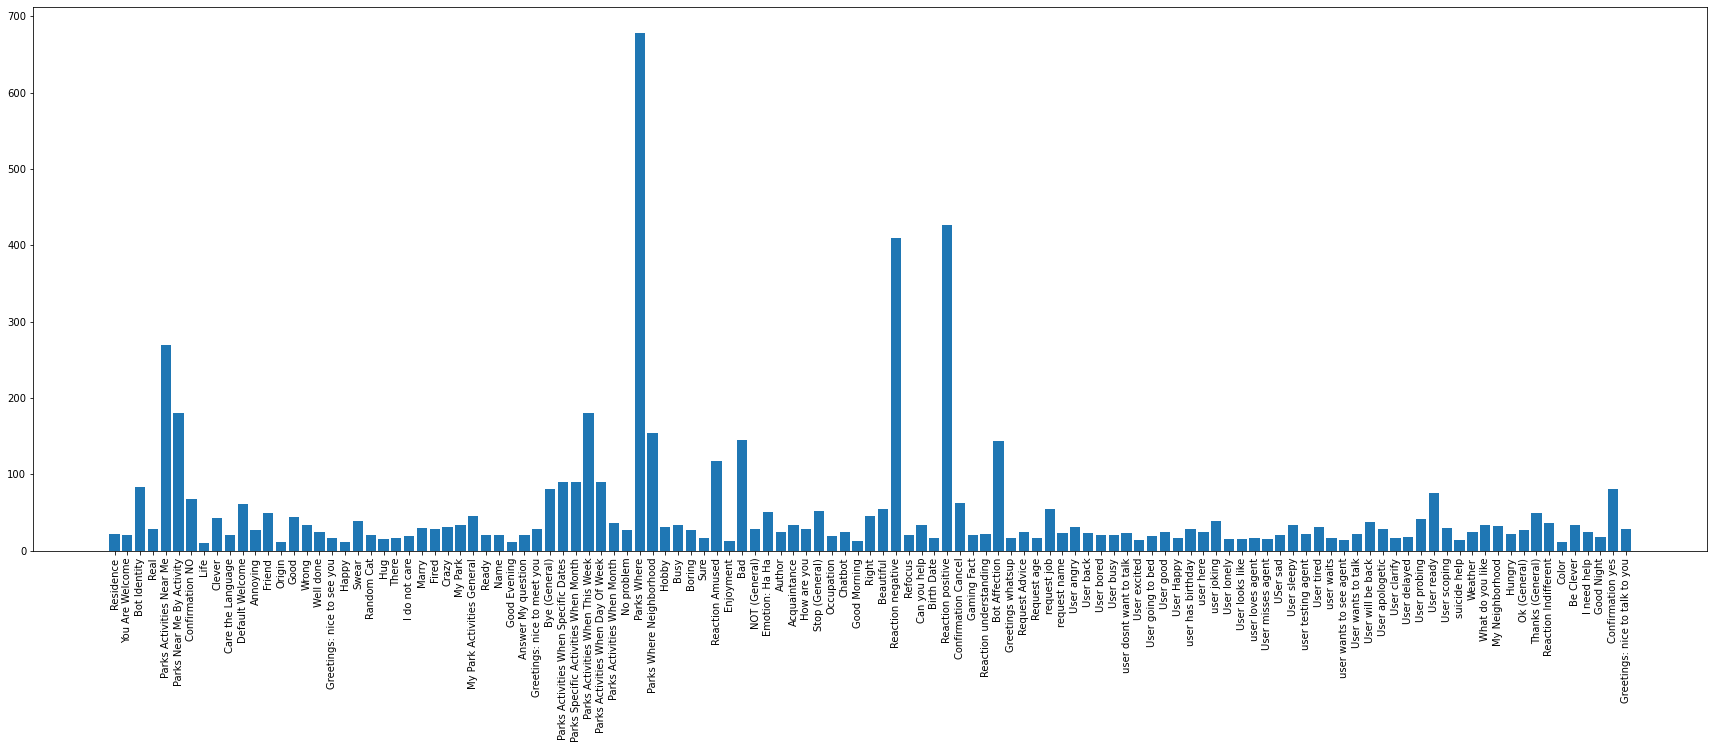

In [124]:
# create a bar chart of all the intents by the number of user phrases
bar_dict = {}
for i in range(0,len(df)):
    if df['tags'].iloc[i] in bar_dict.keys():
        bar_dict[df['tags'].iloc[i]] += 1
    else:
        bar_dict[df['tags'].iloc[i]] = 1
        
# plot graph 
names = list(bar_dict.keys())
values = list(bar_dict.values())

plt.bar(range(len(bar_dict)), values, tick_label=names)
plt.xticks(rotation=90)
#plt.figure(figsize=(5,20))
plt.rcParams["figure.figsize"]=25,25
plt.show()

### Preprocessing The Data

In [128]:
# Split into 80-20 training and testing data
# Y data is the names of the intents (tags) and the X data is the inputted user phrases
X_train, X_test, y_train, y_test = train_test_split(df['user_phrases'], df['tags'].values , test_size=0.20, random_state=0)
# Show the size of datasets
print('X Train Size:',X_train.shape[0])
print('X Test Size:',X_test.shape[0])

X Train Size: 4853
X Test Size: 1214


In [141]:
# Convert the user phrases into tokenized arrays of bag of words with numerical frequencies as values
vectorizer = CountVectorizer(min_df=1)
X_train_counts = vectorizer.fit_transform(X_train).toarray()
X_test_counts = vectorizer.transform(X_test)

In [142]:
# Convert tokenized data into term frequency by inverse document frequency
tfidf_transformer = TfidfTransformer()
# transform train and test data into tfidf form
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts).toarray()
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print('X Train Size:',X_train_tfidf.shape[1])
print('X Test Size:',X_test_tfidf.shape[1])

X Train Size: 1385
X Test Size: 1385


### Random Forest Classifier

In [ ]:
# Use grid search to calculate the best parameters
param_grid = { 
    'n_estimators': [400, 425, 450, 475, 500, 525, 575, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,6,8,16, None],
    'criterion' :['gini', 'entropy']
}
# initialize forest model
rfc = RandomForestClassifier(random_state=33)
# use grid search with 5 cross fold validation
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_tfidf, y_train)

In [161]:
# print out best parameters
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'n_estimators': 600}

In [144]:
# run model with grid search parameters
rfc_tfidf = RandomForestClassifier(random_state=33,criterion = 'gini', max_depth=None, max_features = 'log2', n_estimators=600)
rfc_tfidf.fit(X_train_tfidf, y_train)
pred = rfc_tfidf.predict(X_test_tfidf.toarray())
print(metrics.classification_report(y_test, pred,  digits=5))

                                      precision    recall  f1-score   support

                        Acquaintance    0.60000   0.42857   0.50000         7
                            Annoying    0.50000   0.66667   0.57143         3
                  Answer My question    1.00000   0.50000   0.66667         2
                              Author    1.00000   1.00000   1.00000         6
                                 Bad    0.50000   0.42105   0.45714        38
                           Be Clever    0.75000   1.00000   0.85714         6
                           Beautiful    0.83333   1.00000   0.90909        10
                          Birth Date    1.00000   1.00000   1.00000         2
                              Boring    0.80000   0.66667   0.72727         6
                       Bot Affection    0.58065   0.50000   0.53731        36
                        Bot Identity    0.40000   0.50000   0.44444        12
                                Busy    0.60000   0.42857   0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM Classifier

In [66]:
# Define the parameters to tune
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 'auto', 'scale', 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly','rbf','sigmoid']}
# Tune parameters using Grid Search and a SVC model
model = GridSearchCV(SVC(), parameters, cv=5, n_jobs=-1).fit(X_train_tfidf, y_train)
# Predicting the Test set results
y_pred = model.predict(X_test_tfidf)
# print out stats
print(metrics.classification_report(y_test, y_pred,  digits=5))

                                      precision    recall  f1-score   support

                        Acquaintance    0.66667   0.57143   0.61538         7
                            Annoying    0.50000   0.66667   0.57143         3
                  Answer My question    1.00000   0.50000   0.66667         2
                              Author    1.00000   0.66667   0.80000         6
                                 Bad    0.55556   0.52632   0.54054        38
                           Be Clever    0.85714   1.00000   0.92308         6
                           Beautiful    0.90909   1.00000   0.95238        10
                          Birth Date    0.66667   1.00000   0.80000         2
                              Boring    1.00000   0.66667   0.80000         6
                       Bot Affection    0.64286   0.50000   0.56250        36
                        Bot Identity    0.35294   0.50000   0.41379        12
                                Busy    0.50000   0.42857   0.4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
# output the best paramters
model.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [68]:
# build the model with the best paramters
model = SVC(kernel='rbf', C= 1000, gamma = 0.001, random_state=33)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print(accuracy_score(y_test,y_pred))

0.7751235584843492


### KNN Classifier

In [173]:
# Define the parameters to tune
parameters = { 
    'n_neighbors': [3,5,7,10,15,30],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Tune parameters  using Grid Search and a SVC model
model = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=5, n_jobs=-1).fit(X_train_tfidf, y_train)
# Predicting the Test set results
y_pred = model.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred,  digits=5))

                                      precision    recall  f1-score   support

                        Acquaintance    1.00000   0.25000   0.40000         4
                            Annoying    0.14286   0.50000   0.22222         2
                  Answer My question    1.00000   1.00000   1.00000         6
                              Author    0.87500   0.87500   0.87500         8
                                 Bad    0.23529   0.40000   0.29630        10
                           Be Clever    0.55556   1.00000   0.71429         5
                           Beautiful    0.83333   0.83333   0.83333         6
                          Birth Date    0.60000   1.00000   0.75000         3
                              Boring    0.75000   0.27273   0.40000        11
                       Bot Affection    0.47368   0.56250   0.51429        32
                             Bot Bad    0.09091   0.14286   0.11111         7
                        Bot Identity    0.00000   0.00000   0.0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [174]:
# print out best parameters
model.best_params_

{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

In [61]:
# build model with best parameters
model = neighbors.KNeighborsClassifier(metric = 'manhattan', n_neighbors = 7, weights = 'distance')
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred,  digits=5))

0.7207578253706755


### Comparing model accuracies

In [149]:
Model_names = ['Random Forest', 'SVM', 'KNN']
Metrics = ['Precision','Recall','F1 Score', 'Accuracy']
values = [[0.74107,0.69671,0.69930,0.74465],[0.77726, 0.72902, 0.72844, 0.77512],[0.66186,0.59122,0.59836,0.69205]]
Metrics_data = pd.DataFrame(values, columns=Metrics,index=Model_names)
Metrics_data

,Precision,Recall,F1 Score,Accuracy
Random Forest,0.74107,0.69671,0.69930,0.74465
SVM,0.77726,0.72902,0.72844,0.77512
KNN,0.66186,0.59122,0.59836,0.69205


As seen by the metrics, the SVM model has the highest scores across the board with the accuracy being 3% higher than the random forest model, and 18% higher accuracy than the KNN model. 

### test the SVC model

In [62]:
# train model on 100% of the data
X_train = df['user_phrases']
y_train = df['tags'].values
# vectorize data
vectorizer = CountVectorizer(min_df=1)
X_train_counts = vectorizer.fit_transform(X_train).toarray()

# initialize tfidf
tfidf_transformer = TfidfTransformer()
# transform train and test data into tfidf form
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

model = SVC(kernel='rbf', C= 1000, gamma = 0.001, random_state=33)
model.fit(X_train_tfidf, y_train)

SVC(C=1000, gamma=0.001, random_state=33)

In [150]:
while True:   
    user_response = input('You: ')
    if user_response == 'exit':
        break
    # vectorize user input
    X_user_counts = vectorizer.transform([user_response]).toarray()
    # TF-IDF transform user input
    X_user_tfidf = tfidf_transformer.transform(X_user_counts)
    # predict
    pred = model.predict(X_user_tfidf)
    # match predicted tag with db
    response = list(df[df.tags == pred[0]].bot_responses)[0]
    # select a random response
    output = response[random.randint(0, len(response) - 1)]
    print(f'Parky: {output}')

You: hello
Parky: Hello! How can I help you?
You: can you tell me what you can do
Parky: I'm a Chatbot available to help you 24x7
You: do you have a favorite color?
Parky: As a bot I can't see color but from how i look it looks like I llove pink.
You: okay 
Parky: Sure.
You: can you tell me which park in my neighborhood has yoga
Parky: You picked: $my_neighborhood as your neighborhood
You: is there yoga at Wilson Park
Parky: Heres some activities you can do that are close by:
You: thats not what i asked for
Parky: You seem upset. Let me try and help you.
You: how can you help me
Parky: I'm a Chatbot available to help you 24x7
You: you already said that
Parky: Thanks!  Anything else I can help you with?
You: nope
Parky: Okay.
You: goodbye
Parky: You seem upset. Let me try and help you.
You: im leaving
Parky: Okay, let me know when you are free to chat.
You: exit


### Future work
The model has some trouble with the user inputs as seen by incorrect responses when asking about neighborhood yoga or even when saying goodbye. As seen by the final model, the accuracy is still quite low, so further improvements to the model should come from refining the dataset. The intermediate step of adding user phrases to each intent was successful at raising the initial accuracy of the model seeing as some intents have only 10-20 data points. Expanding and refining the training and testing data can lead to a more accurate model. 

The other method of increasing the accuracy could be to use a different method entirely. Often times natural language processing models will use a nural net model to classify intents. This would potentially create a stronger classifier that would be more accurate than the SVM model.

*Chatbot Application*

While the model needs work, I wanted to still impliment a mid-scale chatbot application. The application still needs plenty of work, however it is fully functional in its current state. The model interfaces with a simple web scraping program that processes the users inputs into json data that posts to the Chicago Parks Department Events and Activities Website. After an intent is classified, a specific variable in the json data is edited from extracting key words from the users inputs. 

The application works by classifying the intent which pairs down which fields of the json data to edit. Then it extracts the key words from their sentences to fill out the data. For instance, if the user enters: "Are there any parks in the Jefferson Park neighborhood that have yoga?" the model will classify their input as searching the site for activites in a specific park. Then, further processing extracts the name of that park, and the name of the activity they are looking for. The json data is edited for those fields, and the website is scraped. The user can then work their way through 20 items at a time to see all available activities.

The main focus of the model was to obtain this specific information about Chicago Parks Activities, however, due to the larger volume of intents, the chatbot can also respond to basic conversation that naturally fills around the specific Parks queries.

To try out the chatbot webscraping, you can find a link to all the files in my github here:
